In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

#importing the required ML packages
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import linear_model

In [2]:
df_S1 = pd.read_csv('train_S1.csv')
df_S2 = pd.read_csv('train_S2.csv')
df_S3 = pd.read_csv('train_S3.csv')

### この章の内容
***
##### 大目標：現在のモデルを洗練させ、今の視野での分析の課題と限界について理解する
0　DateやTimeがSin関数を用いるのとどちらが良いか確認する<br>
1　関係性の強い部分について、交差項を加えて予測する<br>
2　0当てゲームをする<br>
3　Tempに手を加える<br>
4　0当てゲームの後、各項に、必要に応じてlogをとって予測する<br>
5　残差の自己相関を分析する<br>

***

##### 0.1　DateをSin関数で表記する

In [3]:
#元のスコアを先に算出する
#この下でデータを整える
df = df_S1[df_S1['Zero-Time'] == 0].drop(['Zero-Time'] , axis=1)
df['d2'] = df['Date-No'] ** 2
df['d3'] = df['Date-No'] ** 3
df['t2'] = df['Time'] ** 2
df = df.drop('Date-No', axis=1)

#train, testを分けて（10回やって、その平均をスコアとする）
MAE_train = []
MAE_test = []
for i in range(10):
    train,test=train_test_split(df,test_size=0.3,random_state=i)
    train_X=train[train.columns[1:]]
    train_Y=train[train.columns[:1]]
    test_X=test[test.columns[1:]]
    test_Y=test[test.columns[:1]]
    X=df[df.columns[1:]]
    Y=df['Solar1']

    #Lasso回帰
    clf_lasso = linear_model.Lasso(alpha=1.0)
    clf_lasso.fit(train_X, train_Y)

    train_Y['Predicted'] = clf_lasso.predict(train_X.as_matrix())
    train_Y['Predicted'] = train_Y['Predicted'].map(lambda x: 0 if x<0 else x)
    train_Y['Error_abs'] = np.abs(train_Y['Solar1'] - train_Y['Predicted'])

    test_Y['Predicted'] = clf_lasso.predict(test_X.as_matrix())
    test_Y['Predicted'] = test_Y['Predicted'].map(lambda x: 0 if x<0 else x)
    test_Y['Error_abs'] = np.abs(test_Y['Solar1'] - test_Y['Predicted'])

    MAE_train.append(train_Y['Error_abs'].mean())
    MAE_test.append(test_Y['Error_abs'].mean())

print("MAE_train:", np.mean(np.array(MAE_train)))
print("MAE_test:", np.mean(np.array(MAE_test)))

MAE_train: 401.005079762
MAE_test: 400.642142271


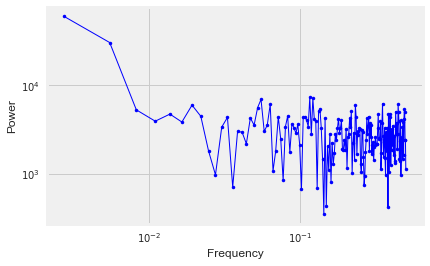

In [4]:
#DateをFFTしてパワースペクトルを見る
date = df_S1.groupby('Date-No')['Solar1'].max()

#FFT
from scipy import fftpack
sample_freq = fftpack.fftfreq(np.array(date).size, d=1)
y_fft = fftpack.fft(np.array(date))
pidxs = np.where(sample_freq > 0)
freqs, power = sample_freq[pidxs], np.abs(y_fft)[pidxs]
freq = freqs[power.argmax()]

#Plot
plt.loglog(freqs, power,'b.-',lw=1)
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.grid(True)

一年と半年の周期が抜けて強い。ここを周期性として拾う。

In [5]:
#この下でデータを整える
df = df_S1[df_S1['Zero-Time'] == 0].drop(['Zero-Time'] , axis=1)
df['sind'] = np.sin(2*np.pi*df['Date-No']/365)
df['cosd'] = np.cos(2*np.pi*df['Date-No']/365)
df['sin2d'] = np.sin(2*np.pi*df['Date-No']/182.5)
df['cos2d'] = np.cos(2*np.pi*df['Date-No']/182.5)
df['t2'] = df['Time'] ** 2
df = df.drop('Date-No', axis=1)

#train, testを分けて（10回やって、その平均をスコアとする）
MAE_train = []
MAE_test = []
for i in range(10):
    train,test=train_test_split(df,test_size=0.3,random_state=i)
    train_X=train[train.columns[1:]]
    train_Y=train[train.columns[:1]]
    test_X=test[test.columns[1:]]
    test_Y=test[test.columns[:1]]
    X=df[df.columns[1:]]
    Y=df['Solar1']

    #Lasso回帰
    clf_lasso = linear_model.Lasso(alpha=1.0)
    clf_lasso.fit(train_X, train_Y)

    train_Y['Predicted'] = clf_lasso.predict(train_X.as_matrix())
    train_Y['Predicted'] = train_Y['Predicted'].map(lambda x: 0 if x<0 else x)
    train_Y['Error_abs'] = np.abs(train_Y['Solar1'] - train_Y['Predicted'])

    test_Y['Predicted'] = clf_lasso.predict(test_X.as_matrix())
    test_Y['Predicted'] = test_Y['Predicted'].map(lambda x: 0 if x<0 else x)
    test_Y['Error_abs'] = np.abs(test_Y['Solar1'] - test_Y['Predicted'])

    MAE_train.append(train_Y['Error_abs'].mean())
    MAE_test.append(test_Y['Error_abs'].mean())

print("MAE_train:", np.mean(np.array(MAE_train)))
print("MAE_test:", np.mean(np.array(MAE_test)))

MAE_train: 394.887469193
MAE_test: 394.775475816


In [6]:
model = pd.ols(y=train_Y['Solar1'], x=train_X, intercept=True)
print(model)


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <Time> + <Rain> + <Temp> + <Wave> + <Clowdy> + <Rainy> + <Snowy>
             + <sind> + <cosd> + <sin2d> + <cos2d> + <t2> + <intercept>

Number of Observations:         28537
Number of Degrees of Freedom:   13

R-squared:         0.6745
Adj R-squared:     0.6744

Rmse:            547.1245

F-stat (12, 28524):  4926.6650, p-value:     0.0000

Degrees of Freedom: model 12, resid 28524

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
          Time  1042.0135     5.5161     188.90     0.0000  1031.2020  1052.8250
          Rain   -10.3739     0.2949     -35.18     0.0000   -10.9519    -9.7959
          Temp    18.6067     1.2119      15.35     0.0000    16.2313    20.9821
          Wave    10.6477     

係数は全て有意。

In [7]:
#365/20の部分のスペクトル（約3番目に影響の大きい項）も加えてみる。
#この下でデータを整える
df = df_S1[df_S1['Zero-Time'] == 0].drop(['Zero-Time'] , axis=1)
df['sind'] = np.sin(2*np.pi*df['Date-No']/365)
df['cosd'] = np.cos(2*np.pi*df['Date-No']/365)
df['sin2d'] = np.sin(2*2*np.pi*df['Date-No']/365)
df['cos2d'] = np.cos(2*2*np.pi*df['Date-No']/365)
df['sinxd'] = np.sin(2*20*np.pi*df['Date-No']/365)
df['cosxd'] = np.cos(2*20*np.pi*df['Date-No']/365)
df['t2'] = df['Time'] ** 2
df = df.drop('Date-No', axis=1)

#train, testを分けて（10回やって、その平均をスコアとする）
MAE_train = []
MAE_test = []
for i in range(10):
    train,test=train_test_split(df,test_size=0.3,random_state=i)
    train_X=train[train.columns[1:]]
    train_Y=train[train.columns[:1]]
    test_X=test[test.columns[1:]]
    test_Y=test[test.columns[:1]]
    X=df[df.columns[1:]]
    Y=df['Solar1']

    #Lasso回帰
    clf_lasso = linear_model.Lasso(alpha=1.0)
    clf_lasso.fit(train_X, train_Y)

    train_Y['Predicted'] = clf_lasso.predict(train_X.as_matrix())
    train_Y['Predicted'] = train_Y['Predicted'].map(lambda x: 0 if x<0 else x)
    train_Y['Error_abs'] = np.abs(train_Y['Solar1'] - train_Y['Predicted'])

    test_Y['Predicted'] = clf_lasso.predict(test_X.as_matrix())
    test_Y['Predicted'] = test_Y['Predicted'].map(lambda x: 0 if x<0 else x)
    test_Y['Error_abs'] = np.abs(test_Y['Solar1'] - test_Y['Predicted'])

    MAE_train.append(train_Y['Error_abs'].mean())
    MAE_test.append(test_Y['Error_abs'].mean())

print("MAE_train:", np.mean(np.array(MAE_train)))
print("MAE_test:", np.mean(np.array(MAE_test)))

MAE_train: 394.498890628
MAE_test: 394.438705438


In [8]:
model = pd.ols(y=train_Y['Solar1'], x=train_X, intercept=True)
print(model)


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <Time> + <Rain> + <Temp> + <Wave> + <Clowdy> + <Rainy> + <Snowy>
             + <sind> + <cosd> + <sin2d> + <cos2d> + <sinxd> + <cosxd> + <t2>
             + <intercept>

Number of Observations:         28537
Number of Degrees of Freedom:   15

R-squared:         0.6750
Adj R-squared:     0.6748

Rmse:            546.7761

F-stat (14, 28522):  4230.9792, p-value:     0.0000

Degrees of Freedom: model 14, resid 28522

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
          Time  1042.2671     5.5129     189.06     0.0000  1031.4618  1053.0724
          Rain   -10.3440     0.2950     -35.06     0.0000   -10.9222    -9.7658
          Temp    18.5778     1.2114      15.34     0.0000    16.2034    20.95

・有意ではあるが、結果に殆ど影響してくれない。既存モデルよりはsincosの方が良さそう。とりあえず４変数のモデルで。必要に応じて増やそう。<br>
・まだ過学習はしていなさそう。

***
0.2　TimeをSin関数で表記する<br>
<br>
既存スコア：MAE_train: 394.887469193　MAE_test: 394.775475816

In [9]:
df = df_S1[df_S1['Zero-Time'] == 0].drop(['Zero-Time'] , axis=1)

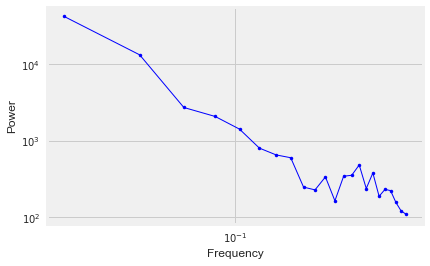

In [10]:
#TimeをFFTしてパワースペクトルを見る
time = df_S1.groupby('Time')['Solar1'].max()

#FFT
from scipy import fftpack
sample_freq = fftpack.fftfreq(np.array(time).size, d=1)
y_fft = fftpack.fft(np.array(time))
pidxs = np.where(sample_freq > 0)
freqs, power = sample_freq[pidxs], np.abs(y_fft)[pidxs]
freq = freqs[power.argmax()]

#Plot
plt.loglog(freqs, power,'b.-',lw=1)
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.grid(True)

In [11]:
#変化が小さい部分を恣意的にカットした
df = df_S1[df_S1['Zero-Time'] == 0].drop(['Zero-Time'] , axis=1)
df['sind'] = np.sin(2*np.pi*df['Date-No']/365)
df['cosd'] = np.cos(2*np.pi*df['Date-No']/365)
df['sin2d'] = np.sin(2*np.pi*df['Date-No']/182.5)
df['cos2d'] = np.cos(2*np.pi*df['Date-No']/182.5)
df['sint'] = np.sin(2*np.pi*(df['Time']-5)/28)
df['cost'] = np.cos(2*np.pi*(df['Time']-5)/28)
df['cos2t'] = np.cos(2*2*np.pi*(df['Time']-5)/28)
df['sin3t'] = np.sin(2*3*np.pi*(df['Time']-5)/28)
df['cos3t'] = np.cos(2*3*np.pi*(df['Time']-5)/28)
df['sin4t'] = np.sin(2*4*np.pi*(df['Time']-5)/28)
df['cos4t'] = np.cos(2*4*np.pi*(df['Time']-5)/28)
df = df.drop(['Date-No','Time'], axis=1)

#train, testを分けて（10回やって、その平均をスコアとする）
MAE_train = []
MAE_test = []
for i in range(10,20):
    train,test=train_test_split(df,test_size=0.3,random_state=i)
    train_X=train[train.columns[1:]]
    train_Y=train[train.columns[:1]]
    test_X=test[test.columns[1:]]
    test_Y=test[test.columns[:1]]
    X=df[df.columns[1:]]
    Y=df['Solar1']

    #Lasso回帰
    clf_lasso = linear_model.Lasso(alpha=1.0)
    clf_lasso.fit(train_X, train_Y)

    train_Y['Predicted'] = clf_lasso.predict(train_X.as_matrix())
    train_Y['Predicted'] = train_Y['Predicted'].map(lambda x: 0 if x<0 else x)
    train_Y['Error_abs'] = np.abs(train_Y['Solar1'] - train_Y['Predicted'])

    test_Y['Predicted'] = clf_lasso.predict(test_X.as_matrix())
    test_Y['Predicted'] = test_Y['Predicted'].map(lambda x: 0 if x<0 else x)
    test_Y['Error_abs'] = np.abs(test_Y['Solar1'] - test_Y['Predicted'])

    MAE_train.append(train_Y['Error_abs'].mean())
    MAE_test.append(test_Y['Error_abs'].mean())

print("MAE_train:", np.mean(np.array(MAE_train)))
print("MAE_test:", np.mean(np.array(MAE_test)))

MAE_train: 361.740892518
MAE_test: 361.903569111


In [12]:
model = pd.ols(y=train_Y['Solar1'], x=train_X, intercept=True)
print(model)


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <Rain> + <Temp> + <Wave> + <Clowdy> + <Rainy> + <Snowy> + <sind>
             + <cosd> + <sin2d> + <cos2d> + <sint> + <cost> + <cos2t> + <sin3t>
             + <cos3t> + <sin4t> + <cos4t> + <intercept>

Number of Observations:         28537
Number of Degrees of Freedom:   18

R-squared:         0.7269
Adj R-squared:     0.7267

Rmse:            500.6335

F-stat (17, 28519):  4465.2354, p-value:     0.0000

Degrees of Freedom: model 17, resid 28519

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
          Rain   -11.3634     0.2713     -41.89     0.0000   -11.8951   -10.8318
          Temp    15.1299     1.1483      13.18     0.0000    12.8792    17.3806
          Wave    11.9239     4.4873       2.6

・この下で全ての変数が高い確率で機能していると言える。より細かいチューニングはまた後で。<br>
・スコアがかなり改善した！

***
##### 1.1　交差項を加える：Weatherたちについて<br>
<br>
既存スコア：MAE_train: 361.740892518　MAE_test: 361.903569111

In [13]:
df = df_S1[df_S1['Zero-Time'] == 0].drop(['Zero-Time'] , axis=1)
df['sind'] = np.sin(2*np.pi*df['Date-No']/365)
df['cosd'] = np.cos(2*np.pi*df['Date-No']/365)
df['sin2d'] = np.sin(2*np.pi*df['Date-No']/182.5)
df['cos2d'] = np.cos(2*np.pi*df['Date-No']/182.5)
df['sint'] = np.sin(2*np.pi*(df['Time']-5)/28)
df['cost'] = np.cos(2*np.pi*(df['Time']-5)/28)
df['cos2t'] = np.cos(2*2*np.pi*(df['Time']-5)/28)
df['sin3t'] = np.sin(2*3*np.pi*(df['Time']-5)/28)
df['cos3t'] = np.cos(2*3*np.pi*(df['Time']-5)/28)
df['sin4t'] = np.sin(2*4*np.pi*(df['Time']-5)/28)
df['cos4t'] = np.cos(2*4*np.pi*(df['Time']-5)/28)
df = df.drop(['Date-No','Time'], axis=1)

df['Rain_Rainy'] = df['Rain'] * df['Rainy']
df['Rain_Cloudy'] = df['Rain'] * df['Clowdy']
df['Rain_Snowy'] = df['Rain'] * df['Snowy']

#train, testを分けて（10回やって、その平均をスコアとする）
MAE_train = []
MAE_test = []
for i in range(10,20):
    train,test=train_test_split(df,test_size=0.3,random_state=i)
    train_X=train[train.columns[1:]]
    train_Y=train[train.columns[:1]]
    test_X=test[test.columns[1:]]
    test_Y=test[test.columns[:1]]
    X=df[df.columns[1:]]
    Y=df['Solar1']

    #Lasso回帰
    clf_lasso = linear_model.Lasso(alpha=1.0)
    clf_lasso.fit(train_X, train_Y)

    train_Y['Predicted'] = clf_lasso.predict(train_X.as_matrix())
    train_Y['Predicted'] = train_Y['Predicted'].map(lambda x: 0 if x<0 else x)
    train_Y['Error_abs'] = np.abs(train_Y['Solar1'] - train_Y['Predicted'])

    test_Y['Predicted'] = clf_lasso.predict(test_X.as_matrix())
    test_Y['Predicted'] = test_Y['Predicted'].map(lambda x: 0 if x<0 else x)
    test_Y['Error_abs'] = np.abs(test_Y['Solar1'] - test_Y['Predicted'])

    MAE_train.append(train_Y['Error_abs'].mean())
    MAE_test.append(test_Y['Error_abs'].mean())

print("MAE_train:", np.mean(np.array(MAE_train)))
print("MAE_test:", np.mean(np.array(MAE_test)))

MAE_train: 361.736669246
MAE_test: 361.962057174


In [14]:
#train, testを分けて（10回やって、その平均をスコアとする）
MAE_train = []
MAE_test = []
for i in range(10,20):
    train,test=train_test_split(df,test_size=0.3,random_state=i)
    train_X=train[train.columns[1:]]
    train_Y=train[train.columns[:1]]
    test_X=test[test.columns[1:]]
    test_Y=test[test.columns[:1]]
    X=df[df.columns[1:]]
    Y=df['Solar1']

    #重回帰分析
    clf = linear_model.LinearRegression()
    clf.fit(train_X, train_Y)

    train_Y['Predicted'] = clf.predict(train_X)
    train_Y['Predicted'] = train_Y['Predicted'].map(lambda x: 0 if x<0 else x)
    train_Y['Error_abs'] = np.abs(train_Y['Solar1'] - train_Y['Predicted'])

    test_Y['Predicted'] = clf.predict(test_X)
    test_Y['Predicted'] = test_Y['Predicted'].map(lambda x: 0 if x<0 else x)
    test_Y['Error_abs'] = np.abs(test_Y['Solar1'] - test_Y['Predicted'])

    MAE_train.append(train_Y['Error_abs'].mean())
    MAE_test.append(test_Y['Error_abs'].mean())

print("MAE_train:", np.mean(np.array(MAE_train)))
print("MAE_test:", np.mean(np.array(MAE_test)))

MAE_train: 360.912008609
MAE_test: 361.174059351


In [15]:
model = pd.ols(y=train_Y['Solar1'], x=train_X, intercept=True)
print(model)


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <Rain> + <Temp> + <Wave> + <Clowdy> + <Rainy> + <Snowy> + <sind>
             + <cosd> + <sin2d> + <cos2d> + <sint> + <cost> + <cos2t> + <sin3t>
             + <cos3t> + <sin4t> + <cos4t> + <Rain_Rainy> + <Rain_Cloudy>
             + <Rain_Snowy> + <intercept>

Number of Observations:         28537
Number of Degrees of Freedom:   21

R-squared:         0.7278
Adj R-squared:     0.7276

Rmse:            499.8098

F-stat (20, 28516):  3812.8249, p-value:     0.0000

Degrees of Freedom: model 20, resid 28516

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
          Rain    -8.5173     0.5756     -14.80     0.0000    -9.6456    -7.3891
          Temp    14.6011     1.1533      12.66     0.0000    12.340

・殆ど変化がない。

In [24]:
del X, Y

***
#### 2　様々な値にlogをとる

※Solarは0以上の値しか取らないので、logをとるのは手としてはあり。<br>
既存スコア：MAE_train: 361.740892518　MAE_test: 361.903569111

###### 2.1  ゼロ当てゲーム（Near 0  : < 100はどちらで判別してもok）

In [3]:
df = df_S1[df_S1['Zero-Time'] == 0].drop(['Zero-Time'] , axis=1)
df = df[(df['Solar1']==0)|(df['Solar1']>= 100)]

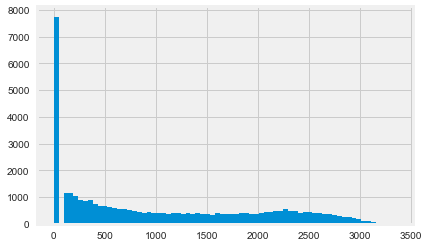

In [26]:
df['Solar1'].hist(bins=70)

In [27]:
df['0-Quiz'] = df['Solar1'].map(lambda x : 1 if x == 0 else 0)
df.groupby('0-Quiz')['0-Quiz'].count()

0-Quiz
0    29569
1     7743
Name: 0-Quiz, dtype: int64

・この分類問題を事前に解くことによって、より回帰が正確になりそう！

In [28]:
#問題設定
df = df_S1[df_S1['Zero-Time'] == 0].drop(['Zero-Time'] , axis=1)
df = df[(df['Solar1']==0)|(df['Solar1']>= 100)]
df['0-Quiz'] = df['Solar1'].map(lambda x : 1 if x == 0 else 0)

df['Time-from-5'] = df['Time'] - 5
df['Time-to-19'] = 19 - df['Time']
df['sind'] = np.sin(2*np.pi*df['Date-No']/365)
df['cosd'] = np.cos(2*np.pi*df['Date-No']/365)
df['sin2d'] = np.sin(2*np.pi*df['Date-No']/182.5)
df['cos2d'] = np.cos(2*np.pi*df['Date-No']/182.5)

df = df.ix[:,['0-Quiz', 'Time-from-5', 'Time-to-19', 'sind', 'cosd', 'sin2d', 'cos2d', 'Rain', 'Temp', 'Wave', 'Clowdy', 'Rainy', 'Snowy']]
df.head()

,0-Quiz,Time-from-5,Time-to-19,sind,cosd,sin2d,cos2d,Rain,Temp,Wave,Clowdy,Rainy,Snowy
9,1,0.0,14.0,0.017213,0.999852,0.034422,0.999407,30.0,4,0.5,1,0,0
10,1,0.5,13.5,0.017213,0.999852,0.034422,0.999407,30.0,4,0.5,1,0,0
11,1,1.0,13.0,0.017213,0.999852,0.034422,0.999407,30.0,4,0.5,1,0,0
12,1,1.5,12.5,0.017213,0.999852,0.034422,0.999407,30.0,4,0.5,1,0,0
13,1,2.0,12.0,0.017213,0.999852,0.034422,0.999407,30.0,4,0.5,1,0,0


In [5]:
#importing all the required ML packages
from sklearn.linear_model import LogisticRegression 
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [29]:
#Split Test and Training
train,test=train_test_split(df,test_size=0.3,random_state=0,stratify=df['0-Quiz'])
train_X=train[train.columns[1:]]
train_Y=train[train.columns[:1]]
test_X=test[test.columns[1:]]
test_Y=test[test.columns[:1]]
X=df[df.columns[1:]]
Y=df['0-Quiz']

In [7]:
#radial SVM
model=svm.SVC(kernel='rbf',C=1,gamma=0.1)
model.fit(train_X,train_Y)
prediction1=model.predict(test_X)
print('Accuracy for rbf SVM is ',metrics.accuracy_score(prediction1,test_Y))

Accuracy for rbf SVM is  0.983562622834


In [32]:
#RF
model=RandomForestClassifier(n_estimators=100)
model.fit(train_X,train_Y)
prediction7=model.predict(test_X)
print('The accuracy of the Random Forests is',metrics.accuracy_score(prediction7,test_Y))

The accuracy of the Random Forests is 0.988207968555


In [33]:
#交差検証を用いた性能評価
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
kfold = KFold(n_splits=10, random_state=22) # k=10, split the data into 10 equal parts
xyz=[]
accuracy=[]
std=[]
classifiers=['Radial Svm','Logistic Regression','KNN','Decision Tree','Naive Bayes','Random Forest']
models=[svm.SVC(kernel='rbf'),LogisticRegression(),KNeighborsClassifier(n_neighbors=9),DecisionTreeClassifier(),GaussianNB(),RandomForestClassifier(n_estimators=100)]
for i in models:
    model = i
    cv_result = cross_val_score(model,X,Y, cv = kfold,scoring = "accuracy")
    xyz.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)
new_models_dataframe2=pd.DataFrame({'CV Mean':xyz,'Std':std},index=classifiers)       
new_models_dataframe2

,CV Mean,Std
Radial Svm,0.977273,0.005982
Logistic Regression,0.797784,0.091871
KNN,0.972502,0.005200
Decision Tree,0.973011,0.007268
Naive Bayes,0.856881,0.054016
Random Forest,0.980650,0.005756


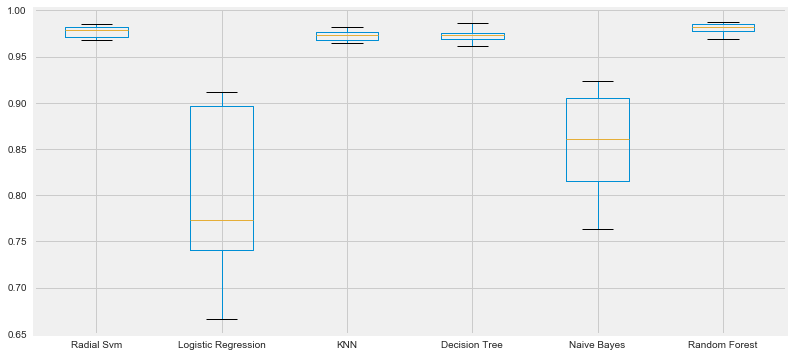

In [34]:
plt.subplots(figsize=(12,6))
box=pd.DataFrame(accuracy,index=[classifiers])
box.T.boxplot()

RandomForestで問題なさそう。

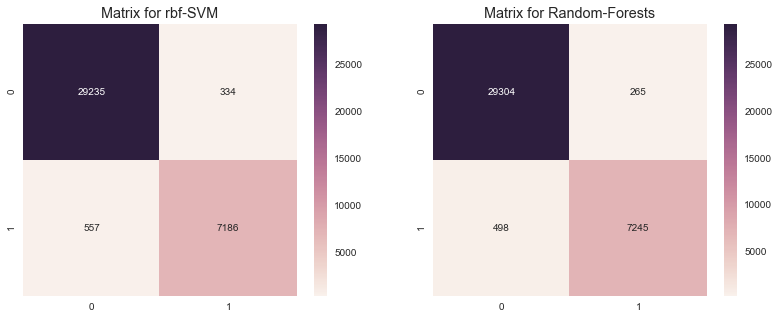

In [11]:
#Confusion Matrix
from sklearn.model_selection import cross_val_predict #prediction
f,ax=plt.subplots(1,2,figsize=(12,5))
y_pred = cross_val_predict(svm.SVC(kernel='rbf'),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0],annot=True,fmt='2.0f')
ax[0].set_title('Matrix for rbf-SVM')
y_pred = cross_val_predict(RandomForestClassifier(n_estimators=100),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1],annot=True,fmt='2.0f')
ax[1].set_title('Matrix for Random-Forests')
plt.show()

よし。

In [13]:
#hyper-parameterのチューニング：RF
from sklearn.model_selection import GridSearchCV
n_estimators=range(100,1000,100)
hyper={'n_estimators':n_estimators}
gd=GridSearchCV(estimator=RandomForestClassifier(random_state=0),param_grid=hyper,verbose=True)
gd.fit(X,Y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  4.2min finished


0.980381646655
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)


・n_estimators = 500で良さそう。

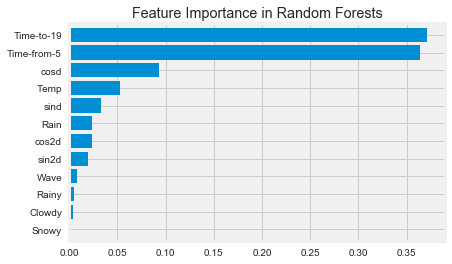

In [18]:
#ちなみに特徴量の貢献度
model=RandomForestClassifier(n_estimators=500,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8)
plt.title('Feature Importance in Random Forests')

・RFでパラメータを500に設定すれば、かなり良い分類ができる。<br>
・これで0を取り除いて、改めて回帰していこう。

#### 3　Tempをしっかり分解したらもっと使えるんじゃないか？？

###### 3.1　0-Quizへの適用

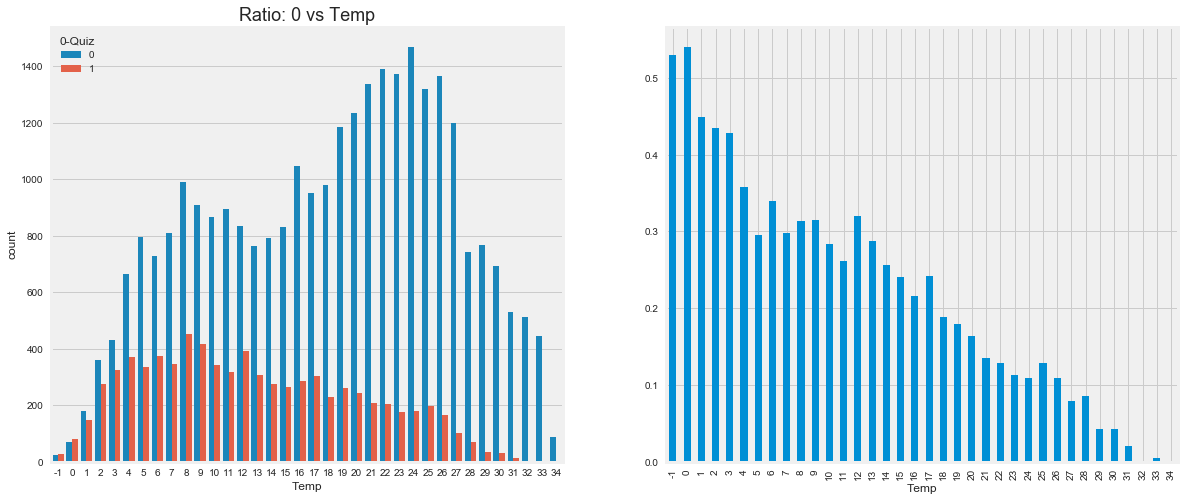

In [24]:
f, ax = plt.subplots(1,2,figsize=(18,8))
sns.countplot('Temp', hue = '0-Quiz', ax=ax[0], data=df)
ax[0].set_title("Count: 0 vs Temp", size = 18)
df.groupby("Temp")['0-Quiz'].mean().plot.bar(ax=ax[1])
ax[0].set_title("Ratio: 0 vs Temp", size = 18)

・かなり線形の貢献率。このままで問題なさそう。

###### 3.2　回帰への適用

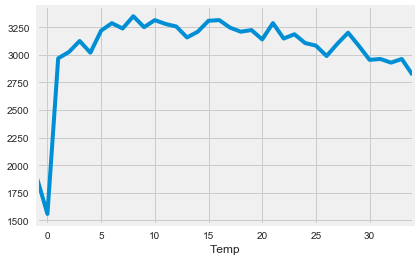

In [25]:
df_S1.groupby('Temp')['Solar1'].max().plot()

・これは線形とは言いづらい。二次、三次、四次の項を加えて予測してみる。

In [27]:
#変化が小さい部分を恣意的にカットした
df = df_S1[df_S1['Zero-Time'] == 0].drop(['Zero-Time'] , axis=1)
df['sind'] = np.sin(2*np.pi*df['Date-No']/365)
df['cosd'] = np.cos(2*np.pi*df['Date-No']/365)
df['sin2d'] = np.sin(2*np.pi*df['Date-No']/182.5)
df['cos2d'] = np.cos(2*np.pi*df['Date-No']/182.5)
df['sint'] = np.sin(2*np.pi*(df['Time']-5)/28)
df['cost'] = np.cos(2*np.pi*(df['Time']-5)/28)
df['cos2t'] = np.cos(2*2*np.pi*(df['Time']-5)/28)
df['sin3t'] = np.sin(2*3*np.pi*(df['Time']-5)/28)
df['cos3t'] = np.cos(2*3*np.pi*(df['Time']-5)/28)
df['sin4t'] = np.sin(2*4*np.pi*(df['Time']-5)/28)
df['cos4t'] = np.cos(2*4*np.pi*(df['Time']-5)/28)
df['Temp2'] = df['Temp'] ** 2
df['Temp3'] = df['Temp'] ** 3

df = df.drop(['Date-No','Time'], axis=1)

#train, testを分けて（10回やって、その平均をスコアとする）
MAE_train = []
MAE_test = []
for i in range(10,20):
    train,test=train_test_split(df,test_size=0.3,random_state=i)
    train_X=train[train.columns[1:]]
    train_Y=train[train.columns[:1]]
    test_X=test[test.columns[1:]]
    test_Y=test[test.columns[:1]]
    X=df[df.columns[1:]]
    Y=df['Solar1']

    #Lasso回帰
    clf_lasso = linear_model.Lasso(alpha=1.0)
    clf_lasso.fit(train_X, train_Y)

    train_Y['Predicted'] = clf_lasso.predict(train_X.as_matrix())
    train_Y['Predicted'] = train_Y['Predicted'].map(lambda x: 0 if x<0 else x)
    train_Y['Error_abs'] = np.abs(train_Y['Solar1'] - train_Y['Predicted'])

    test_Y['Predicted'] = clf_lasso.predict(test_X.as_matrix())
    test_Y['Predicted'] = test_Y['Predicted'].map(lambda x: 0 if x<0 else x)
    test_Y['Error_abs'] = np.abs(test_Y['Solar1'] - test_Y['Predicted'])

    MAE_train.append(train_Y['Error_abs'].mean())
    MAE_test.append(test_Y['Error_abs'].mean())

print("MAE_train:", np.mean(np.array(MAE_train)))
print("MAE_test:", np.mean(np.array(MAE_test)))

MAE_train: 360.362959763
MAE_test: 360.416128156


・殆ど変化しなかった（ほんの少しの改善）。

***
### 4　Solar=0を省いた回帰

In [70]:
#0でないものからモデルを作る
df = df_S1[df_S1['Solar1'] != 0].drop(['Zero-Time'] , axis=1)

df['sind'] = np.sin(2*np.pi*df['Date-No']/365)
df['cosd'] = np.cos(2*np.pi*df['Date-No']/365)
df['sin2d'] = np.sin(2*np.pi*df['Date-No']/182.5)
df['cos2d'] = np.cos(2*np.pi*df['Date-No']/182.5)
df['sint'] = np.sin(2*np.pi*(df['Time']-5)/28)
df['sin3t'] = np.sin(2*3*np.pi*(df['Time']-5)/28)
df['cos3t'] = np.cos(2*3*np.pi*(df['Time']-5)/28)
df['sin4t'] = np.sin(2*4*np.pi*(df['Time']-5)/28)
df['cos4t'] = np.cos(2*4*np.pi*(df['Time']-5)/28)
df = df.drop(['Date-No','Time'], axis=1)

#train, testを分けて（10回やって、その平均をスコアとする）
MAE_train = []
MAE_test = []
for i in range(10,20):
    train,test=train_test_split(df,test_size=0.3,random_state=i)
    train_X=train[train.columns[1:]]
    train_Y=train[train.columns[:1]]
    test_X=test[test.columns[1:]]
    test_Y=test[test.columns[:1]]
    X=df[df.columns[1:]]
    Y=df['Solar1']

    #Lasso回帰
    clf_lasso = linear_model.Lasso(alpha=1.0)
    clf_lasso.fit(train_X, train_Y)

    train_Y['Predicted'] = clf_lasso.predict(train_X.as_matrix())
    train_Y['Predicted'] = train_Y['Predicted'].map(lambda x: 0 if x<0 else x)
    train_Y['Error_abs'] = np.abs(train_Y['Solar1'] - train_Y['Predicted'])

    test_Y['Predicted'] = clf_lasso.predict(test_X.as_matrix())
    test_Y['Predicted'] = test_Y['Predicted'].map(lambda x: 0 if x<0 else x)
    test_Y['Error_abs'] = np.abs(test_Y['Solar1'] - test_Y['Predicted'])

    MAE_train.append(train_Y['Error_abs'].mean())
    MAE_test.append(test_Y['Error_abs'].mean())

print("MAE_train:", np.mean(np.array(MAE_train)))
print("MAE_test:", np.mean(np.array(MAE_test)))

MAE_train: 391.280125174
MAE_test: 392.463183287


変わらん。

In [43]:
#Logを取りましょう
df = df_S1[df_S1['Solar1'] != 0].drop(['Zero-Time'] , axis=1)

df['Solar1'] = np.log(df['Solar1'])
df['sind'] = np.sin(2*np.pi*df['Date-No']/365)
df['cosd'] = np.cos(2*np.pi*df['Date-No']/365)
df['sin2d'] = np.sin(2*np.pi*df['Date-No']/182.5)
df['cos2d'] = np.cos(2*np.pi*df['Date-No']/182.5)
df['sint'] = np.sin(2*np.pi*(df['Time']-5)/28)
df['cost'] = np.cos(2*np.pi*(df['Time']-5)/28)
df['cos2t'] = np.cos(2*2*np.pi*(df['Time']-5)/28)
df['sin3t'] = np.sin(2*3*np.pi*(df['Time']-5)/28)
df['cos3t'] = np.cos(2*3*np.pi*(df['Time']-5)/28)
df['sin4t'] = np.sin(2*4*np.pi*(df['Time']-5)/28)
df['cos4t'] = np.cos(2*4*np.pi*(df['Time']-5)/28)
df = df.drop(['Date-No','Time'], axis=1)

#train, testを分けて（10回やって、その平均をスコアとする）
MAE_train = []
MAE_test = []
for i in range(10,20):
    train,test=train_test_split(df,test_size=0.3,random_state=i)
    train_X=train[train.columns[1:]]
    train_Y=train[train.columns[:1]]
    test_X=test[test.columns[1:]]
    test_Y=test[test.columns[:1]]
    X=df[df.columns[1:]]
    Y=df['Solar1']

    #Lasso回帰
    clf_lasso = linear_model.Lasso(alpha=1.0)
    clf_lasso.fit(train_X, train_Y)

    train_Y['Predicted'] = clf_lasso.predict(train_X.as_matrix())
    train_Y['Predicted'] = train_Y['Predicted'].map(lambda x: 0 if x<0 else x)
    train_Y['Error_abs'] = np.abs(np.exp(train_Y['Solar1']) - np.exp(train_Y['Predicted']))

    test_Y['Predicted'] = clf_lasso.predict(test_X.as_matrix())
    test_Y['Predicted'] = test_Y['Predicted'].map(lambda x: 0 if x<0 else x)
    test_Y['Error_abs'] = np.abs(np.exp(test_Y['Solar1']) - np.exp(test_Y['Predicted']))

    MAE_train.append(train_Y['Error_abs'].mean())
    MAE_test.append(test_Y['Error_abs'].mean())

print("MAE_train:", np.mean(np.array(MAE_train)))
print("MAE_test:", np.mean(np.array(MAE_test)))

MAE_train: 780.905993897
MAE_test: 778.783974074


ふえたね

In [48]:
#色々Logを取りましょう
df = df_S1[df_S1['Solar1'] != 0].drop(['Zero-Time'] , axis=1)

lis = ['Solar1', 'Date-No']
for i in lis:
    df[i] = np.log(df[i])

df['sind'] = np.sin(2*np.pi*df['Date-No']/365)
df['cosd'] = np.cos(2*np.pi*df['Date-No']/365)
df['sin2d'] = np.sin(2*np.pi*df['Date-No']/182.5)
df['cos2d'] = np.cos(2*np.pi*df['Date-No']/182.5)
df['sint'] = np.sin(2*np.pi*(df['Time']-5)/28)
df['cost'] = np.cos(2*np.pi*(df['Time']-5)/28)
df['cos2t'] = np.cos(2*2*np.pi*(df['Time']-5)/28)
df['sin3t'] = np.sin(2*3*np.pi*(df['Time']-5)/28)
df['cos3t'] = np.cos(2*3*np.pi*(df['Time']-5)/28)
df['sin4t'] = np.sin(2*4*np.pi*(df['Time']-5)/28)
df['cos4t'] = np.cos(2*4*np.pi*(df['Time']-5)/28)
df = df.drop(['Date-No','Time'], axis=1)

#train, testを分けて（10回やって、その平均をスコアとする）
MAE_train = []
MAE_test = []
for i in range(10,20):
    train,test=train_test_split(df,test_size=0.3,random_state=i)
    train_X=train[train.columns[1:]]
    train_Y=train[train.columns[:1]]
    test_X=test[test.columns[1:]]
    test_Y=test[test.columns[:1]]
    X=df[df.columns[1:]]
    Y=df['Solar1']

    #Lasso回帰
    clf_lasso = linear_model.Lasso(alpha=1.0)
    clf_lasso.fit(train_X, train_Y)

    train_Y['Predicted'] = clf_lasso.predict(train_X.as_matrix())
    train_Y['Predicted'] = train_Y['Predicted'].map(lambda x: 0 if x<0 else x)
    train_Y['Error_abs'] = np.abs(np.exp(train_Y['Solar1']) - np.exp(train_Y['Predicted']))

    test_Y['Predicted'] = clf_lasso.predict(test_X.as_matrix())
    test_Y['Predicted'] = test_Y['Predicted'].map(lambda x: 0 if x<0 else x)
    test_Y['Error_abs'] = np.abs(np.exp(test_Y['Solar1']) - np.exp(test_Y['Predicted']))

    MAE_train.append(train_Y['Error_abs'].mean())
    MAE_test.append(test_Y['Error_abs'].mean())

print("MAE_train:", np.mean(np.array(MAE_train)))
print("MAE_test:", np.mean(np.array(MAE_test)))

MAE_train: 780.905993897
MAE_test: 778.783974074


・安直にやるだけだと上手く行かないことがわかりました。

#実際の分析の手続き

#0-Quizの後、indexとpredictionのdf_qを生成したのち、
df_S1 = pd.merge(df_S1, df_q, left_index=True, right_index=True, how='outer')
df_S1['Predict-Zero'] = 0
df_S1.loc[(df['Zero-Time'] == 1)|(df['Q-Ans'] == 1), 'Predict-Zero'] = 1

df.loc[(df['Fare']>7.91)&(df['Fare']<=14.454),'Fare_cat']=1

***
### 5　残差分析

In [3]:
#0でないものからモデルを作る
df = df_S1[df_S1['Solar1'] != 0].drop(['Zero-Time'] , axis=1)
df['sind'] = np.sin(2*np.pi*df['Date-No']/365)
df['cosd'] = np.cos(2*np.pi*df['Date-No']/365)
df['sin2d'] = np.sin(2*np.pi*df['Date-No']/182.5)
df['cos2d'] = np.cos(2*np.pi*df['Date-No']/182.5)
df['sint'] = np.sin(2*np.pi*(df['Time']-5)/28)
df['sin3t'] = np.sin(2*3*np.pi*(df['Time']-5)/28)
df['cos3t'] = np.cos(2*3*np.pi*(df['Time']-5)/28)
df['sin4t'] = np.sin(2*4*np.pi*(df['Time']-5)/28)
df['cos4t'] = np.cos(2*4*np.pi*(df['Time']-5)/28)
tmp = df.ix[:,['Date-No', 'Time']]
df = df.drop(['Date-No','Time'], axis=1)

X=df[df.columns[1:]]
Y=df['Solar1']
df = pd.concat([tmp, df], axis=1)

#Lasso回帰
clf_lasso = linear_model.Lasso(alpha=1.0)
clf_lasso.fit(X, Y)
df['Predicted'] = clf_lasso.predict(X.as_matrix())
df['Predicted'] = df['Predicted'].map(lambda x: 0 if x<0 else x)
df['Residuals'] = df['Solar1'] - df['Predicted']
df['Error_abs'] = np.abs(df['Solar1'] - df['Predicted'])

print("MAE:", df['Error_abs'].mean())

MAE: 391.734837318685


In [49]:
#決定係数
((df['Predicted'] - df['Predicted'].mean()) ** 2).sum() / ((df['Solar1'] - df['Solar1'].mean()) ** 2).sum()

0.6312576148809707

・まだ半分弱の残差を説明できていない（改善の余地あり）。

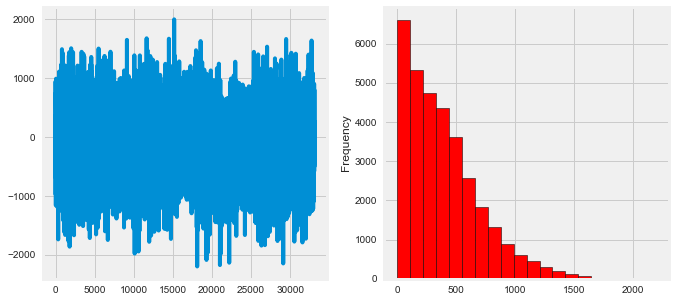

In [50]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(np.arange(len(df['Residuals'])), df['Residuals'])
plt.subplot(1,2,2)
np.abs(df['Residuals']).plot.hist(bins=20,edgecolor='black',color='red')

In [4]:
pd.DataFrame(df['Residuals'].describe())

,Residuals
count,33061.000000
mean,-16.854071
std,504.041470
min,-2197.702978
25%,-328.212380
50%,26.604861
75%,325.799130
max,1994.000000


・一つの方針（メモ）：どのような時に残差が大きくなるかを把握して、危険察知ないし別の回帰を用いる

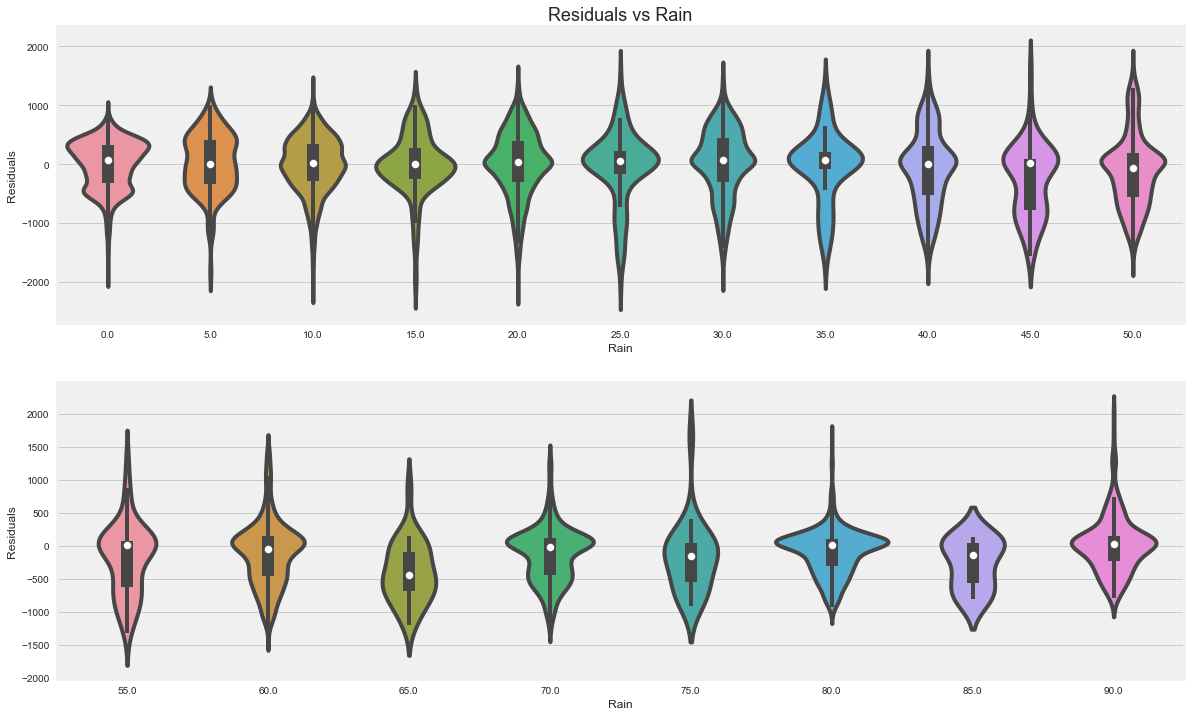

In [5]:
f,ax=plt.subplots(2,1,figsize=(18,12))

#Rainとずれの大きさ
sns.violinplot("Rain","Residuals",data=df[df['Rain']<=50],split=True,ax=ax[0])
ax[0].set_title('Residuals vs Rain', fontsize=18)
sns.violinplot("Rain","Residuals",data=df[df['Rain']>50],split=True,ax=ax[1])

In [8]:
a = df.groupby('Rain')['Residuals'].describe()
b = {}
for i in np.arange(0.0, 95, 5):
    b[i] = a[i]
pd.DataFrame(b)

,0.0,5.0,10.0,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0,60.0,65.0,70.0,75.0,80.0,85.0,90.0
count,7479.000000,347.000000,10313.000000,387.000000,5282.000000,171.000000,2822.000000,92.000000,1147.000000,73.000000,2097.000000,50.000000,1148.000000,30.000000,669.000000,27.000000,666.000000,12.000000,249.000000
mean,-1.763011,23.803908,-2.459539,3.051786,8.325772,-37.949320,26.060012,-36.709336,-76.015898,-269.830911,-104.776881,-196.153117,-116.880891,-407.662008,-132.775464,-188.014576,-91.877687,-272.377487,21.806833
std,417.542953,486.289533,480.613570,508.478720,552.593601,600.828172,579.046825,583.872110,636.279337,606.867727,611.241259,536.261484,489.379923,450.484143,410.181722,525.823177,340.274672,371.777530,421.887952
min,-1934.239478,-1844.235293,-2197.702978,-2134.212587,-2174.422235,-2035.621299,-1906.340770,-1634.407604,-1715.572339,-1563.771402,-1623.799193,-1321.015974,-1344.714544,-1203.224880,-1229.256928,-913.622605,-992.737870,-812.027666,-796.231260
25%,-315.546445,-342.794961,-284.812493,-247.012971,-297.283366,-157.019427,-306.795093,-78.311929,-528.010680,-776.730401,-547.599252,-620.675075,-457.053941,-686.623712,-440.023595,-549.187372,-306.134567,-561.789909,-237.743953
50%,76.805998,13.222734,24.178379,0.041257,35.770058,49.000000,70.000000,70.500000,4.000000,14.000000,-57.526628,14.291110,-43.674786,-445.493120,-15.507065,-152.623214,5.000000,-141.194996,21.000000
75%,326.624112,419.269391,348.264159,280.962517,391.553314,226.000000,439.039171,215.500000,312.340686,87.000000,188.000000,71.000000,148.129164,-99.904669,114.000000,47.000000,110.000000,41.250000,153.226820
max,923.686228,1011.221226,1332.153928,1268.320612,1469.533633,1503.213586,1500.494115,1314.144534,1625.506511,1596.307447,1672.641475,1261.639927,1445.321233,861.815447,1304.871367,1665.650399,1634.678965,134.000000,1994.000000


・Rain=0で残差が小さくなりにくい<br>
・Rainが45, 55, 65, 75, 85のときに見積もりが大きくなりすぎてしまう傾向がある<br>
・65では400も、45では269、85では272、55と75では200弱の誤差である<br>
・Rainが20~55の部分は標準誤差が大きい

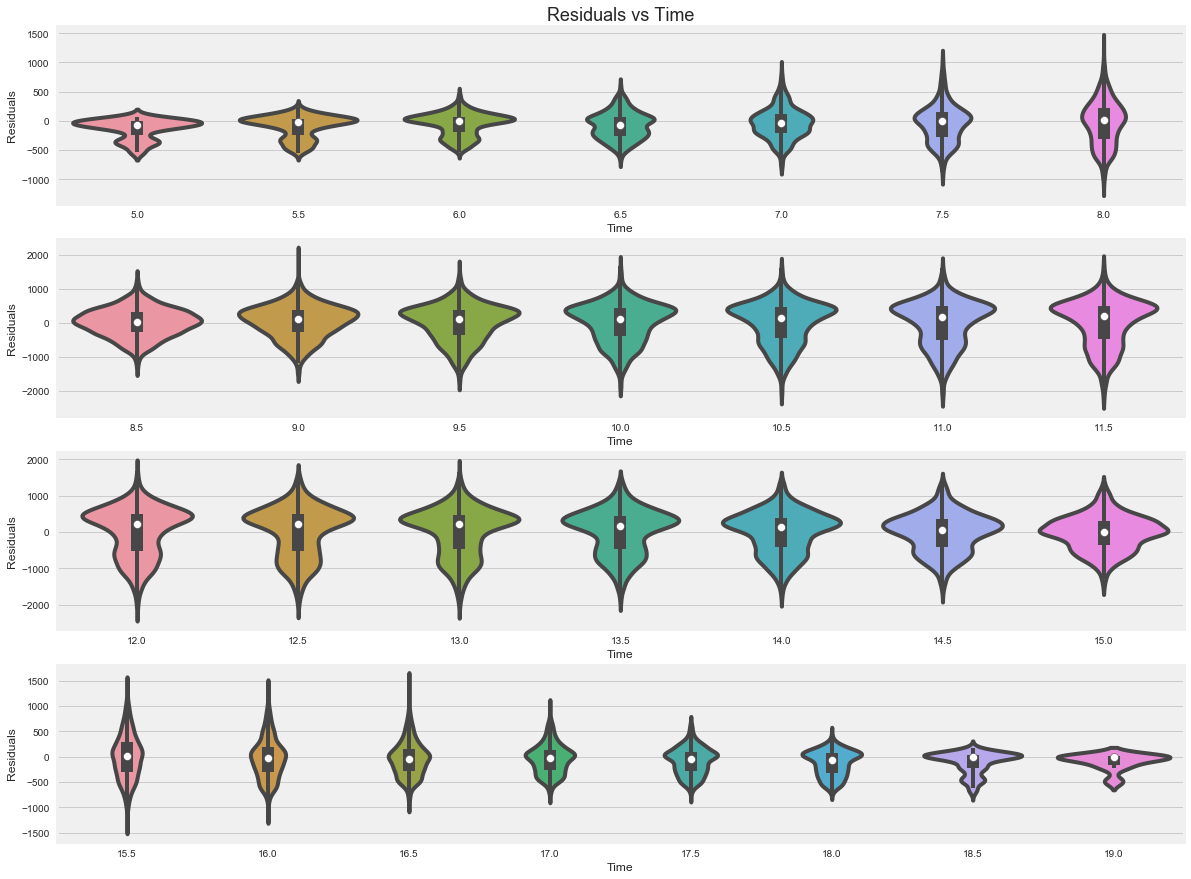

In [9]:
f,ax=plt.subplots(4,1,figsize=(18,15))

#Timeとずれの大きさ
sns.violinplot("Time","Residuals",data=df[df['Time'] <= 8],split=True,ax=ax[0])
ax[0].set_title('Residuals vs Time', fontsize=18)
sns.violinplot("Time","Residuals",data=df[(df['Time'] > 8) & (df['Time'] <= 11.5)],split=True,ax=ax[1])
sns.violinplot("Time","Residuals",data=df[(df['Time'] > 11.5) & (df['Time'] <= 15)],split=True,ax=ax[2])
sns.violinplot("Time","Residuals",data=df[(df['Time'] > 15)],split=True,ax=ax[3])

In [11]:
pd.options.display.max_columns = None
a = df.groupby('Time')['Residuals'].describe()
b = {}
for i in np.arange(5.0, 19.5, 0.5):
    b[i] = a[i]
pd.DataFrame(b)

,5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5,9.0,9.5,10.0,10.5,11.0,11.5,12.0,12.5,13.0,13.5,14.0,14.5,15.0,15.5,16.0,16.5,17.0,17.5,18.0,18.5,19.0
count,97.000000,386.000000,646.000000,874.000000,1091.000000,1376.000000,1425.000000,1444.000000,1446.000000,1448.000000,1446.000000,1445.000000,1448.000000,1446.000000,1447.000000,1448.000000,1449.000000,1447.000000,1448.000000,1446.000000,1443.000000,1431.000000,1403.000000,1301.000000,1019.000000,806.000000,581.000000,338.000000,36.000000
mean,-133.277088,-92.423277,-52.171281,-77.574961,-35.740023,-43.448802,-27.010450,9.319533,39.164703,-2.595927,2.723930,-4.749477,-6.871438,1.195021,12.383177,7.943345,2.567371,5.877058,-7.017580,-11.748918,-21.135513,3.120555,-30.875011,-38.518965,-41.078730,-80.604293,-124.250900,-111.368941,-94.291016
std,167.822042,191.374241,194.583984,228.605773,262.200862,315.265419,377.169301,414.247687,476.372827,530.731612,575.693720,618.101308,654.158399,678.819372,677.524027,685.272381,656.813479,615.283525,577.623366,532.534947,477.403888,436.017228,392.474341,337.100416,288.967830,263.080044,244.972794,215.527703,158.745027
min,-534.621760,-551.847341,-527.534706,-661.832302,-778.712882,-931.345064,-1099.858778,-1356.080712,-1503.466276,-1723.455338,-1879.759832,-2096.311516,-2146.713400,-2197.702978,-2134.212587,-2040.218480,-2066.769517,-1870.893926,-1770.712875,-1677.926356,-1497.034682,-1314.097648,-1127.533806,-925.713665,-761.685601,-753.554453,-706.215317,-720.773103,-497.574941
25%,-245.013955,-247.109320,-197.312581,-253.014169,-206.518585,-276.243476,-315.887635,-276.104883,-267.691483,-359.815970,-406.078651,-462.131040,-494.862569,-491.525898,-523.488172,-537.775852,-481.032879,-474.759684,-425.724933,-401.453338,-349.370909,-308.989262,-306.242644,-282.275383,-260.785367,-286.416694,-316.850200,-224.791400,-172.245585
50%,-74.406637,-13.484193,6.000000,-76.866307,-30.411364,-6.108033,10.979040,31.000000,97.988233,96.334256,119.589073,147.820695,166.358527,200.005593,222.113785,224.473945,213.426991,170.539549,125.937810,61.416573,10.078918,12.083554,-32.436712,-36.356403,-20.663263,-42.036411,-66.261228,-1.944039,-9.575029
75%,4.000000,37.499606,75.000000,75.990870,120.200056,149.899503,226.085846,302.416918,375.059568,372.000797,428.912653,455.323785,491.048420,498.220843,500.131739,499.229540,456.090577,439.831084,395.688173,346.677969,298.947837,282.679439,194.310503,160.000000,130.860471,95.717210,69.709096,35.000000,5.250000
max,67.000000,232.000000,452.000000,602.000000,887.238899,1059.606717,1302.392188,1334.000000,1994.000000,1560.986994,1672.641475,1601.107733,1597.399727,1646.200389,1665.650399,1530.477457,1660.708356,1391.568849,1373.602254,1365.324258,1302.541810,1371.643744,1333.207587,1498.851415,980.918221,657.000000,444.000000,178.000000,30.000000


・やはりお昼の分散が大きい。<br>
・明け方（5, 5.5）と夕方（18, 18.5, 19）は見積もりが大きくなってしまう傾向がある。

In [29]:
#これまでを実践する（ここは45, 65ダミーを作っただけ。回帰式を二本用意する作戦はまだ試す余地あり）
df = df_S1[df_S1['Solar1'] != 0].drop(['Zero-Time'] , axis=1)

df['sind'] = np.sin(2*np.pi*df['Date-No']/365)
df['cosd'] = np.cos(2*np.pi*df['Date-No']/365)
df['sin2d'] = np.sin(2*np.pi*df['Date-No']/182.5)
df['cos2d'] = np.cos(2*np.pi*df['Date-No']/182.5)
df['sint'] = np.sin(2*np.pi*(df['Time']-5)/28)
df['sin3t'] = np.sin(2*3*np.pi*(df['Time']-5)/28)
df['cos3t'] = np.cos(2*3*np.pi*(df['Time']-5)/28)
df['sin4t'] = np.sin(2*4*np.pi*(df['Time']-5)/28)
df['cos4t'] = np.cos(2*4*np.pi*(df['Time']-5)/28)

df['Rain-45'] = df['Rain'].map(lambda x: 1 if x == 45 else 0)
df['Rain-65'] = df['Rain'].map(lambda x: 1 if x == 65 else 0)
df = df.drop(['Date-No','Time'], axis=1)

#train, testを分けて（10回やって、その平均をスコアとする）
MAE_train = []
MAE_test = []
for i in range(10,20):
    train,test=train_test_split(df,test_size=0.3,random_state=i)
    train_X=train[train.columns[1:]]
    train_Y=train[train.columns[:1]]
    test_X=test[test.columns[1:]]
    test_Y=test[test.columns[:1]]
    X=df[df.columns[1:]]
    Y=df['Solar1']

    #Lasso回帰
    clf_lasso = linear_model.Lasso(alpha=1.0)
    clf_lasso.fit(train_X, train_Y)

    train_Y['Predicted'] = clf_lasso.predict(train_X.as_matrix())
    train_Y['Predicted'] = train_Y['Predicted'].map(lambda x: 0 if x<0 else x)
    train_Y['Error_abs'] = np.abs(train_Y['Solar1'] - train_Y['Predicted'])

    test_Y['Predicted'] = clf_lasso.predict(test_X.as_matrix())
    test_Y['Predicted'] = test_Y['Predicted'].map(lambda x: 0 if x<0 else x)
    test_Y['Error_abs'] = np.abs(test_Y['Solar1'] - test_Y['Predicted'])

    MAE_train.append(train_Y['Error_abs'].mean())
    MAE_test.append(test_Y['Error_abs'].mean())

print("MAE_train:", np.mean(np.array(MAE_train)))
print("MAE_test:", np.mean(np.array(MAE_test)))

MAE_train: 391.280125174
MAE_test: 392.463183287


In [30]:
model = pd.ols(y=train_Y['Solar1'], x=train_X, intercept=True)
print(model)


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <Rain> + <Temp> + <Wave> + <Clowdy> + <Rainy> + <Snowy> + <sind>
             + <cosd> + <sin2d> + <cos2d> + <sint> + <sin3t> + <cos3t> + <sin4t>
             + <cos4t> + <Rain-45> + <Rain-65> + <intercept>

Number of Observations:         23142
Number of Degrees of Freedom:   18

R-squared:         0.6946
Adj R-squared:     0.6944

Rmse:            515.3671

F-stat (17, 23124):  3094.1250, p-value:     0.0000

Degrees of Freedom: model 17, resid 23124

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
          Rain   -15.0920     0.3100     -48.69     0.0000   -15.6995   -14.4844
          Temp    10.1149     1.2042       8.40     0.0000     7.7547    12.4751
          Wave    17.3373     5.1897     

全然値が変わってくれない。→変数が多すぎる？？（PCAしてみるか）

In [3]:
#(100-Rain)*Sint*Sindの項を加えてみる（ほんのり非線形への拡張）
df = df_S1[df_S1['Solar1'] != 0].drop(['Zero-Time'] , axis=1)

df['sind'] = np.sin(2*np.pi*df['Date-No']/365)
df['cosd'] = np.cos(2*np.pi*df['Date-No']/365)
df['sin2d'] = np.sin(2*np.pi*df['Date-No']/182.5)
df['cos2d'] = np.cos(2*np.pi*df['Date-No']/182.5)
df['sint'] = np.sin(2*np.pi*(df['Time']-5)/28)
df['sin3t'] = np.sin(2*3*np.pi*(df['Time']-5)/28)
df['cos3t'] = np.cos(2*3*np.pi*(df['Time']-5)/28)
df['sin4t'] = np.sin(2*4*np.pi*(df['Time']-5)/28)
df['cos4t'] = np.cos(2*4*np.pi*(df['Time']-5)/28)

df['Rain'] = 1-df['Rain'] / 100
df['Time'] = 1605.7756* df['sint'] -497.7458* df['sin3t'] -497.7458 * df['cos4t']
df['Date'] = (178.4168 * df['sind'] - 319.7585 * df['cosd'])

df['m'] = df['Rain'] * df['Time']
df['m1'] = df['Time'] * df['Date']
df['m2'] = df['Rain'] * df['Date']
df['m3'] = df['Rain'] * df['Date'] * df['Time']
  
df = df.drop(['Date-No','Time', 'Date', 'Cloudy'], axis=1)

#train, testを分けて（10回やって、その平均をスコアとする）
MAE_train = []
MAE_test = []
for i in range(10,20):
    train,test=train_test_split(df,test_size=0.3,random_state=i)
    train_X=train[train.columns[1:]]
    train_Y=train[train.columns[:1]]
    test_X=test[test.columns[1:]]
    test_Y=test[test.columns[:1]]
    X=df[df.columns[1:]]
    Y=df['Solar1']

    #Lasso回帰
    clf_lasso = linear_model.Lasso(alpha=1.0)
    clf_lasso.fit(train_X, train_Y)

    train_Y['Predicted'] = clf_lasso.predict(train_X.as_matrix())
    train_Y['Predicted'] = train_Y['Predicted'].map(lambda x: 0 if x<0 else x)
    train_Y['Error_abs'] = np.abs(train_Y['Solar1'] - train_Y['Predicted'])

    test_Y['Predicted'] = clf_lasso.predict(test_X.as_matrix())
    test_Y['Predicted'] = test_Y['Predicted'].map(lambda x: 0 if x<0 else x)
    test_Y['Error_abs'] = np.abs(test_Y['Solar1'] - test_Y['Predicted'])

    MAE_train.append(train_Y['Error_abs'].mean())
    MAE_test.append(test_Y['Error_abs'].mean())

print("MAE_train:", np.mean(np.array(MAE_train)))
print("MAE_test:", np.mean(np.array(MAE_test)))

MAE_train: 354.447967237
MAE_test: 355.842163856


In [43]:
model = pd.ols(y=train_Y['Solar1'], x=train_X, intercept=True)
print(model)


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <Rain> + <Temp> + <Wave> + <Clowdy> + <Rainy> + <Snowy> + <sind>
             + <cosd> + <sin2d> + <cos2d> + <sint> + <sin3t> + <cos3t> + <sin4t>
             + <cos4t> + <m> + <m1> + <m2> + <m3> + <intercept>

Number of Observations:         23142
Number of Degrees of Freedom:   20

R-squared:         0.7326
Adj R-squared:     0.7323

Rmse:            482.3200

F-stat (19, 23122):  3333.3892, p-value:     0.0000

Degrees of Freedom: model 19, resid 23122

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
          Rain  -827.9373    56.2503     -14.72     0.0000  -938.1880  -717.6867
          Temp     5.6040     1.1383       4.92     0.0000     3.3730     7.8350
          Wave    16.9205     4.8579  

In [44]:
355 * 28 / 48

207.08333333333334